## Fraud detection project (IEEE-CIS)

#### Loading the necessary modules

In [167]:
from zipfile import ZipFile

import pandas as pd

import numpy as np

import sklearn as sk

import matplotlib.pyplot as plt

from sklearn.preprocessing import scale

import random

import seaborn as sns

from sklearn_pandas import CategoricalImputer

from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import OneHotEncoder

import category_encoders as ce

from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression

%matplotlib inline

#### Loading data

In [169]:
zf=ZipFile('ieee-fraud-detection.zip', 'r')

train_id=pd.read_csv(zf.open('train_identity.csv'))

train_tr=pd.read_csv(zf.open('train_transaction.csv'))

test_id=pd.read_csv(zf.open('test_identity.csv'))

test_tr=pd.read_csv(zf.open('test_transaction.csv'))

#### Merge data

In [171]:
train=pd.merge(train_id,train_tr,on='TransactionID')

test=pd.merge(test_id,test_tr,on='TransactionID')

#### Observing what is the proportion of fraud cases in the data

In [173]:
100*train[train['isFraud']==1].shape[0]/train.shape[0]

7.847025299342037

#### Creating a dataframe with Name (feature name) and Missing (% of missing values) columns

In [175]:
null_name=list(train.columns)

null_value=[100*train[i].isnull().sum()/train.shape[0] for i in null_name]

null_df=pd.DataFrame()

null_df['Name']=null_name

null_df['Missing']=null_value

#### Plotting features with missing values exceeding 50 % of total rows 

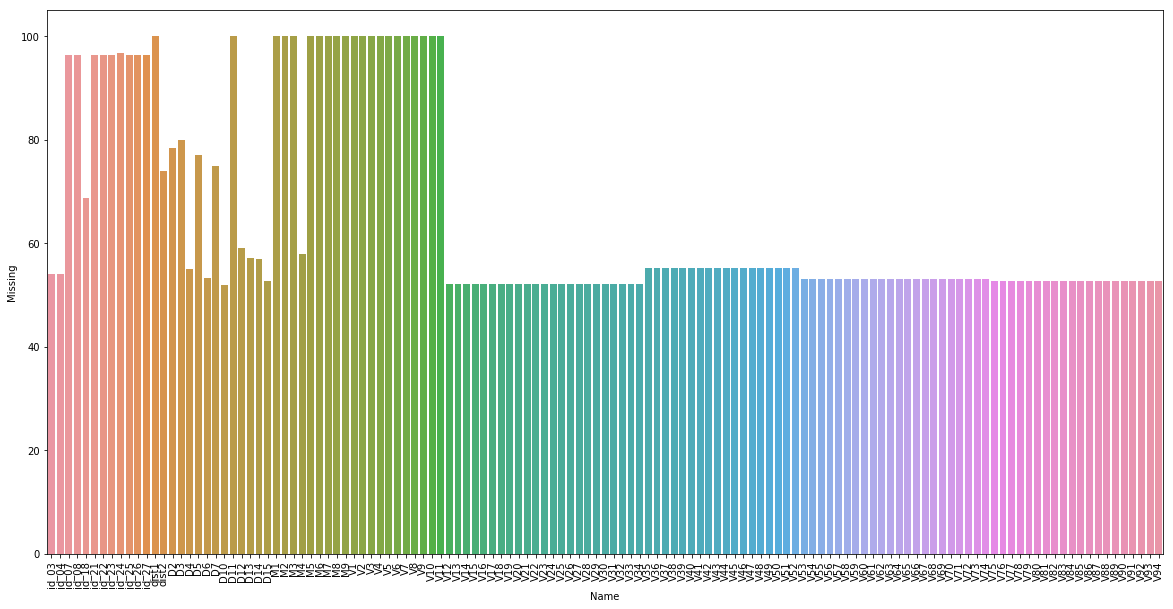

In [176]:
plt.figure(figsize=(20,10))

chart=sns.barplot(x="Name", y="Missing", data=null_df[null_df['Missing']>50])

chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

chart

#### As we can see from the chart above there are columns which contain no info (100 % missing). So, let's remove them.

In [178]:
train.drop(list(null_df[null_df['Missing']==100]['Name']),axis=1,inplace=True)

test.drop(list(null_df[null_df['Missing']==100]['Name']),axis=1,inplace=True)

#### Creat a list with categorical features' names

In [180]:
cat_names=['ProductCD','addr1','addr2','P_emaildomain','R_emaildomain','DeviceType','DeviceInfo','M4']

for i in range(1,7):
    
    cat_names.append('card'+str(i))
    
for i in range(12,39):
    
    cat_names.append('id_'+str(i))

#### Replace missing values in categorical variables

In [182]:
cat_train=train[cat_names]

cat_test=test[cat_names]

for i in cat_names:

    cat_train[i].fillna(cat_train[i].mode()[0],inplace=True)
    
    cat_test[i].fillna(cat_test[i].mode()[0],inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


#### Replace missing values in numerical features and splitting the target from features

In [184]:
Y_train=train['isFraud']

train.drop('isFraud',axis=1,inplace=True)

num_train=train.drop(cat_names,axis=1)

num_test=test.drop(cat_names,axis=1)

not_string_features=[i for i in num_train.columns if type(num_train[i].iloc[0])!=str]

for i in not_string_features:

    num_train[i].fillna(num_train[i].median(),inplace=True)
    
    num_test[i].fillna(num_test[i].median(),inplace=True)

#### Label enconding and one hot encoding for test and train data

In [186]:
str_cat_names=[i for i in cat_names if type(cat_train[i].iloc[0])==str]

str_cat_train=cat_train[str_cat_names]

cat_train.drop(str_cat_names,axis=1,inplace=True)

str_cat_test=cat_test[str_cat_names]

cat_test.drop(str_cat_names,axis=1,inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [187]:
le = LabelEncoder()

for i in str_cat_names:

        str_cat_train.loc[:,i+'_le']=le.fit_transform(str_cat_train[i])

        str_cat_train.drop(i,axis=1,inplace=True)
        
        str_cat_test.loc[:,i+'_le']=le.fit_transform(str_cat_test[i])

        str_cat_test.drop(i,axis=1,inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [189]:
sub_cat_names=[i+'_le' for i in str_cat_names if len(str_cat_train[i+'_le'].unique())<=7]

ohe = ce.OneHotEncoder(handle_unknown='ignore')

cat_train_ohe = ohe.fit_transform(str_cat_train[sub_cat_names])

cat_test_ohe = ohe.transform(str_cat_test[sub_cat_names])

In [190]:
str_cat_train.drop(sub_cat_names,axis=1,inplace=True)

str_cat_test.drop(sub_cat_names,axis=1,inplace=True)

In [191]:
str_cat_train=pd.concat([str_cat_train,cat_train_ohe],axis=1)

cat_train=pd.concat([cat_train,str_cat_train],axis=1)

str_cat_test=pd.concat([str_cat_test,cat_test_ohe],axis=1)

cat_test=pd.concat([cat_test,str_cat_test],axis=1)

#### Extracting features for train and test

In [193]:
X_train=pd.concat([num_train,cat_train],axis=1)

X_test=pd.concat([num_test,cat_test],axis=1)

#### Conducting PCA

In [195]:
scaler = StandardScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)

X_test = scaler.transform(X_test)

pca = PCA(.95)

pca.fit(X_train)

X_train = pca.transform(X_train)

X_test = pca.transform(X_test)

#### Logistic regression estimation

In [196]:
logisticRegr = LogisticRegression(solver = 'lbfgs', max_iter=500)

logisticRegr.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [197]:
logisticRegr.score(X_train, Y_train)

In [ ]:
pred_test=logisticRegr.predict(X_test)